In [ ]:
# default_exp ratio_images

In [ ]:
# hide
# from nbdev.showdoc import *

# ratio_images

> API details.

In [ ]:
# export
import re

import numpy as np
import pandas as pd
from py_clone_detective.utils import extend_region_properties_list, generate_random_cmap
from skimage import img_as_float, io, measure

In [ ]:
# export
def create_img_dict_from_folder(
    load_pattern: str, img_regex: str = r"\w\dg\d\d?", label: bool = False, **kwargs
):
    img_collection = io.ImageCollection(load_pattern, **kwargs)

    img_dict = {
        re.search(img_regex, file)[0]: img_collection[i]
        for i, file in enumerate(img_collection.files)
    }

    if label:
        img_dict = {key: measure.label(value) for key, value in img_dict.items()}

    else:
        img_dict = {key: img_as_float(value) for key, value in img_dict.items()}

    return img_dict

In [ ]:
C0_imgs = create_img_dict_from_folder(load_pattern="data/PercevalHR_data/imgs/*C0.tiff")
C1_imgs = create_img_dict_from_folder(load_pattern="data/PercevalHR_data/imgs/*C1.tiff")
C1_imgs.keys()

dict_keys(['a1g1', 'a1g2', 'a1g3', 'a1g4', 'a1g5', 'a1g6', 'a1g7', 'a1g8', 'a1g9', 'a1g10', 'a2g1', 'a2g2', 'a2g3', 'a2g6', 'a2g9'])

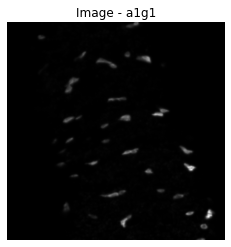

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(C1_imgs["a1g1"], cmap="gray")
ax.set_title("Image - a1g1")
ax.set_axis_off()

In [ ]:
lab_imgs = create_img_dict_from_folder(
    load_pattern="data/PercevalHR_data/masks/*.tif", label=True
)

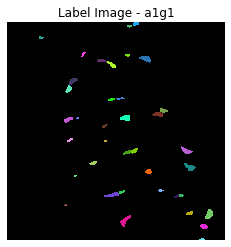

In [ ]:
fig, ax = plt.subplots()
ax.imshow(lab_imgs["a1g1"], cmap=generate_random_cmap(), interpolation="none")
ax.set_title("Label Image - a1g1")
ax.set_axis_off()

In [ ]:
# export
def create_ratio_image(num_img, denom_img, mask_img):
    # convert label image to mask if passed
    mask_img = mask_img > 0
    ratio = num_img[mask_img] / denom_img[mask_img]
    ratio_image = np.zeros_like(num_img)
    ratio_image[mask_img] = ratio
    return ratio_image

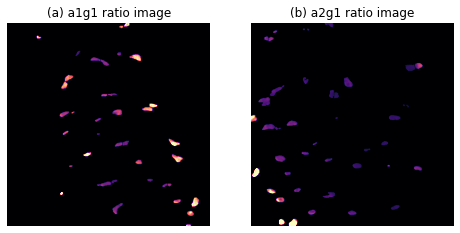

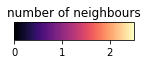

In [ ]:
from py_clone_detective.utils import plot_new_images

a1g1_img = create_ratio_image(C1_imgs["a1g1"], C0_imgs["a1g1"], lab_imgs["a1g1"])
a2g1_img = create_ratio_image(C1_imgs["a2g1"], C0_imgs["a2g1"], lab_imgs["a2g1"])

plot_new_images(
    [a1g1_img, a2g1_img],
    ["a1g1 ratio image", "a2g1 ratio image"],
    img_cmap="magma",
    vmax=2.5,
    figure_shape=(1, 2),
    figure_size=(8, 5),
    colorbar=True,
)

In [ ]:
# export
def create_dict_of_ratio_images(num_imgs: dict, denom_imgs: dict, lab_imgs: dict):
    ratio_img_dict = {}
    for img_key, lab_img in lab_imgs.items():
        ratio_img_dict[img_key] = create_ratio_image(
            num_imgs[img_key], denom_imgs[img_key], lab_img
        )
    return ratio_img_dict

In [ ]:
ratio_imgs = create_dict_of_ratio_images(C1_imgs, C0_imgs, lab_imgs)

In [ ]:
ratio_imgs.keys()

dict_keys(['a1g1', 'a1g2', 'a1g3', 'a1g4', 'a1g5', 'a1g6', 'a1g7', 'a1g8', 'a1g9', 'a1g10', 'a2g1', 'a2g2', 'a2g3', 'a2g6', 'a2g9'])

In [ ]:
# export
def measure_region_props_to_tidy_df(int_imgs: dict, lab_imgs: dict, **reg_prop_kwargs):
    l = list()
    for img_key, img in int_imgs.items():
        df = pd.DataFrame(
            measure.regionprops_table(
                lab_imgs[img_key], intensity_image=img, **reg_prop_kwargs
            )
        )
        df["img_key"] = img_key

        l.append(df)

    return pd.concat(l)

In [ ]:
df = measure_region_props_to_tidy_df(
    C1_imgs, lab_imgs, properties=["label", "mean_intensity"]
)

In [ ]:
df.head()

,label,mean_intensity,img_key
0,1,0.030962,a1g1
1,2,0.019942,a1g1
2,3,0.020551,a1g1
3,4,0.025653,a1g1
4,5,0.023319,a1g1


In [ ]:
# export
def only_intensity_region_properties(properties):
    return [prop for prop in properties if re.search(r"label|intensity", prop)]

In [ ]:
only_intensity_region_properties(["label", "area", "mean_intensity", "centroid"])

['label', 'mean_intensity']

In [ ]:
# export
def ratiometric_measure_region_props_to_tidy_df(
    num_imgs: dict,
    denom_imgs: dict,
    lab_imgs: dict,
    region_properties: list = None,
    **reg_prop_kwargs
):
    num_rprops = extend_region_properties_list(region_properties)
    denom_rprops = only_intensity_region_properties(num_rprops)

    df = pd.merge(
        measure_region_props_to_tidy_df(num_imgs, lab_imgs, properties=num_rprops),
        measure_region_props_to_tidy_df(denom_imgs, lab_imgs, properties=denom_rprops),
        how="left",
        on=("img_key", "label"),
        suffixes=("_num", "_denom"),
    )

    return df.eval("ratio_mean_int = mean_intensity_num/mean_intensity_denom")

In [ ]:
df = ratiometric_measure_region_props_to_tidy_df(C1_imgs, C0_imgs, lab_imgs)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int
0,1,100,0.030962,4.000000,301.900000,a1g1,0.013425,2.306226
1,2,49,0.019942,9.183673,287.693878,a1g1,0.011463,1.739765
2,3,54,0.020551,35.555556,79.296296,a1g1,0.009241,2.223765
3,4,76,0.025653,75.763158,178.513158,a1g1,0.047491,0.540171
4,5,67,0.023319,77.447761,282.626866,a1g1,0.027246,0.855851


In [ ]:
# export
def split_img_key_col_to_sample_id_and_replicates(
    df,
    split_regex: str,
    img_key_colname: str = "img_key",
    sample_id_colname: str = "sample_id",
    replicate_id_colname: str = "rep_id",
):
    temp_df = df[img_key_colname].str.split(split_regex, expand=True).iloc[:, :2]
    temp_df.columns = [sample_id_colname, replicate_id_colname]

    return pd.concat([df, temp_df], axis=1)

In [ ]:
df = split_img_key_col_to_sample_id_and_replicates(
    df, sample_id_colname="genotype", split_regex=r"g"
)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int,genotype,rep_id
0,1,100,0.030962,4.000000,301.900000,a1g1,0.013425,2.306226,a1,1
1,2,49,0.019942,9.183673,287.693878,a1g1,0.011463,1.739765,a1,1
2,3,54,0.020551,35.555556,79.296296,a1g1,0.009241,2.223765,a1,1
3,4,76,0.025653,75.763158,178.513158,a1g1,0.047491,0.540171,a1,1
4,5,67,0.023319,77.447761,282.626866,a1g1,0.027246,0.855851,a1,1


In [ ]:
# export
def sample_id_to_categories(
    df,
    sample_id_colname: str = "sample_id",
    old_to_new_sample_ids: dict = None,
    categories: list = None,
):
    if old_to_new_sample_ids is not None:
        df[sample_id_colname].replace(old_to_new_sample_ids, inplace=True)

    df[sample_id_colname] = pd.Categorical(df[sample_id_colname], categories=categories)

    return df

In [ ]:
df = sample_id_to_categories(
    df, sample_id_colname="genotype", old_to_new_sample_ids={"a1": "ctrl", "a2": "mut"}
)
df.head()

,label,area,mean_intensity_num,centroid-0,centroid-1,img_key,mean_intensity_denom,ratio_mean_int,genotype,rep_id
0,1,100,0.030962,4.000000,301.900000,a1g1,0.013425,2.306226,ctrl,1
1,2,49,0.019942,9.183673,287.693878,a1g1,0.011463,1.739765,ctrl,1
2,3,54,0.020551,35.555556,79.296296,a1g1,0.009241,2.223765,ctrl,1
3,4,76,0.025653,75.763158,178.513158,a1g1,0.047491,0.540171,ctrl,1
4,5,67,0.023319,77.447761,282.626866,a1g1,0.027246,0.855851,ctrl,1


In [ ]:
df["genotype"].head()

0    ctrl
1    ctrl
2    ctrl
3    ctrl
4    ctrl
Name: genotype, dtype: category
Categories (2, object): ['ctrl', 'mut']